<a href="https://colab.research.google.com/github/adarshkaushal18/audio-noise-reduction-FIR-LSTM/blob/main/Audio_Signal_Noise_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

In [ ]:
from scipy.signal.windows import kaiser
from scipy.signal import lfilter
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
sample_rate, audio_signal = wav.read('TF026.WAV')

In [ ]:
audio_signal = audio_signal / np.max(np.abs(audio_signal))

In [ ]:
noise = np.random.normal(0, 0.1, len(audio_signal))
noisy_audio = audio_signal + noise

In [ ]:
def design_fir_filter(numtaps, cutoff, beta):
    taps = np.kaiser(numtaps, beta)
    taps /= np.sum(taps)
    return taps

numtaps = 101
cutoff = 0.1
beta = 8.6
fir_filter = design_fir_filter(numtaps, cutoff, beta)

In [ ]:
def create_dataset(signal, window_size):
    X, y = [], []
    for i in range(len(signal) - window_size):
        X.append(signal[i:i + window_size])
        y.append(signal[i + window_size])
    return np.array(X), np.array(y)

window_size = numtaps
X, y = create_dataset(noisy_audio, window_size)

In [ ]:
# Check the shapes of X and y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

if len(X) == 0 or len(y) == 0:
    print("The dataset is empty. Please check the length of the signal and the window size.")
else:
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Reshape data for LSTM model
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Build a more complex machine learning model
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=(window_size, 1)),
        Dropout(0.2),
        Bidirectional(LSTM(128)),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

    # Predict and apply the filter
    filtered_signal = model.predict(X_test)
    filtered_signal = filtered_signal.flatten()

    # Evaluate the performance
    def evaluate_performance(original, filtered):
        mse = np.mean((original - filtered) ** 2)
        snr = 10 * np.log10(np.sum(original ** 2) / np.sum((original - filtered) ** 2))
        return mse, snr

    mse, snr = evaluate_performance(audio_signal[len(audio_signal) - len(filtered_signal):], filtered_signal)
    print(f'MSE: {mse}, SNR: {snr}')

Shape of X: (60531, 101)
Shape of y: (60531,)
Epoch 1/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - loss: 0.1111 - val_loss: 0.0203
Epoch 2/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - loss: 0.0238 - val_loss: 0.0190
Epoch 3/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - loss: 0.0205 - val_loss: 0.0164
Epoch 4/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0196 - val_loss: 0.0174
Epoch 5/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0200 - val_loss: 0.0170
Epoch 6/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0181 - val_loss: 0.0163
Epoch 7/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.0173 - val_loss: 0.0150
Epoch 8/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.0170 - val_loss: 0.0149
Epoch 9/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.0166 - val_loss: 0.0148
Epoch 10/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 0.0167 - val_loss: 0.0145
Epoch 11/100
757/757 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss:

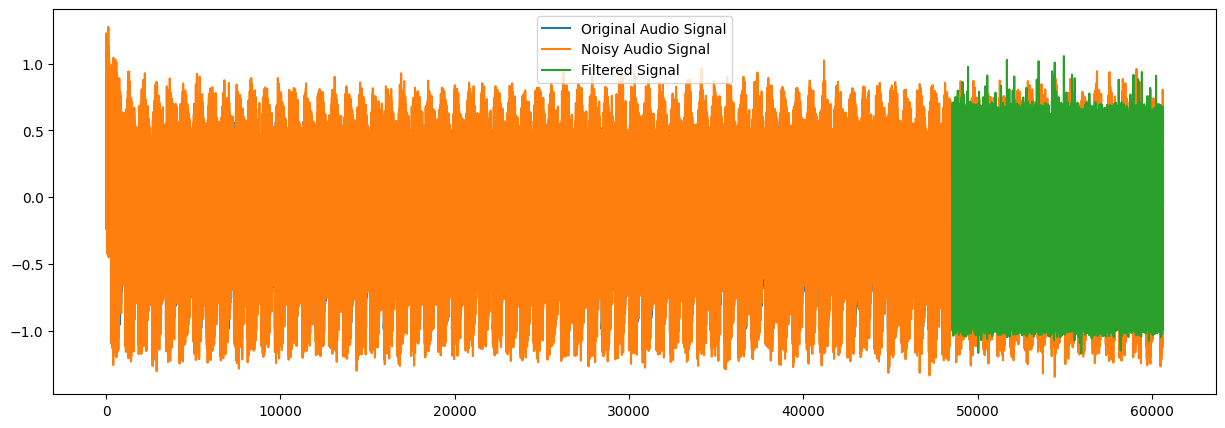

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(audio_signal, label='Original Audio Signal')
plt.plot(noisy_audio, label='Noisy Audio Signal')
plt.plot(np.arange(len(noisy_audio) - len(filtered_signal), len(noisy_audio)), filtered_signal, label='Filtered Signal')
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Check the shapes of X and y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

if len(X) == 0 or len(y) == 0:
    print("The dataset is empty. Please check the length of the signal and the window size.")
else:
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Reshape data for LSTM model
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Build a more complex machine learning model
    model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(window_size, 1)),
    Dropout(0.3),
    BatchNormalization(),
    Bidirectional(LSTM(256)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)
    ])

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse')

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])


    # Predict and apply the filter
    filtered_signal = model.predict(X_test)
    filtered_signal = filtered_signal.flatten()

    # Evaluate the performance
    def evaluate_performance(original, filtered):
        mse = np.mean((original - filtered) ** 2)
        snr = 10 * np.log10(np.sum(original ** 2) / np.sum((original - filtered) ** 2))
        return mse, snr

    mse, snr = evaluate_performance(audio_signal[len(audio_signal) - len(filtered_signal):], filtered_signal)
    print(f'MSE: {mse}, SNR: {snr}')

Shape of X: (60531, 101)
Shape of y: (60531,)
Epoch 1/200
757/757 ━━━━━━━━━━━━━━━━━━━━ 44s 52ms/step - loss: 0.8352 - val_loss: 0.1310
Epoch 2/200
757/757 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - loss: 0.3074 - val_loss: 0.1009
Epoch 3/200
757/757 ━━━━━━━━━━━━━━━━━━━━ 80s 52ms/step - loss: 0.1926 - val_loss: 0.0842
Epoch 4/200
757/757 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - loss: 0.1449 - val_loss: 0.0652
Epoch 5/200
757/757 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step - loss: 0.1088 - val_loss: 0.0511
Epoch 6/200
757/757 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.0898 - val_loss: 0.0382
Epoch 7/200
757/757 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.0725 - val_loss: 0.0303
Epoch 8/200
757/757 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - loss: 0.0612 - val_loss: 0.0248
Epoch 9/200
757/757 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.0521 - val_loss: 0.0231
Epoch 10/200
757/757 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.0476 - val_loss: 0.0201
Epoch 11/200
757/757 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss:

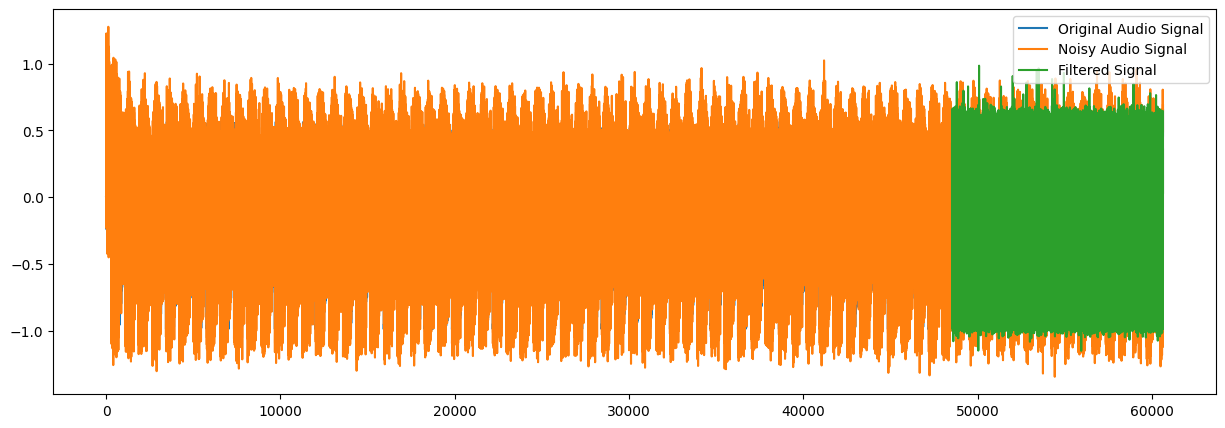

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(audio_signal, label='Original Audio Signal')
plt.plot(noisy_audio, label='Noisy Audio Signal')
plt.plot(np.arange(len(noisy_audio) - len(filtered_signal), len(noisy_audio)), filtered_signal, label='Filtered Signal')
plt.legend()
plt.show()